In [1]:
%%javascript
// Git Commit Button - JavaScript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_NAME = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
# Git Commit Button
from IPython.display import display, Javascript
import ipywidgets as widgets
import sh

commit_button = widgets.Button(description="Git commit")
display(commit_button)
# display_button = widgets.Button(description="Git commit")
# display(button)

def do_commit(b):
    display(Javascript('IPython.notebook.save_checkpoint();'))
    print(sh.git.add(NOTEBOOK_NAME))
    print(sh.git.status())
    print(sh.git.commit(m="Automatic commit triggered by in-script button"))
    print(sh.git.push("origin","master"))

#     print(git.status())

commit_button.on_click(do_commit)

Button(description='Git commit', style=ButtonStyle())

Start by preserving Morvan Zhou's docstring.  I can't bring myself to delete it, even though the information is included in the header cell of this notebook.

In [3]:
"""
Know more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
tensorflow: 1.1.0
matplotlib
numpy
"""

'\nKnow more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/\nMy Youtube Channel: https://www.youtube.com/user/MorvanZhou\nDependencies:\ntensorflow: 1.1.0\nmatplotlib\nnumpy\n'

Do imports, set up some parameters.  They're called hyperparameters because we're not trying to find them *automatically*, we set them up ourselves.  So they're stronger, more fundamental than the other parameters, the weight matrices and bias vectors?

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# CONFIG

# Hyper Parameters
TIME_STEP = 100       # rnn time step
#INPUT_SIZE = 1      # rnn input size (we later make this 93 for our own data)
CELL_SIZE = 10000      # rnn cell size (number of weights)
LR = 0.2           # learning rate
checkpoint_filename = "checkpoints/danceData"
looping_frames = 2000

In [5]:
# PROGRESS BAR
# https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    try:
        label = HTML()
        box = VBox(children=[label, progress])
        display(box)
    except Exception:
        yield from sequence
    

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

Morvan Zhou's sinusoidal data example. Substituted with our own data, thus commented out.

In [6]:
# Build, and show, data
# steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
# x_np = np.sin(steps); y_np = np.cos(steps)    # float32 for converting torch FloatTensor
# plt.plot(steps, y_np, 'r-', label='target (cos)'); plt.plot(steps, x_np, 'b-', label='input (sin)')
# plt.legend(loc='best'); plt.show()

Load the data using numpy's `genfromtxt` function.  I have to look that function up every time I use it.

For RNN's data should be $n_b \times n_t \times n_x$, where 
* $n_b$ is for batching, which we aren't yet using, and is therefore 1,
* $n_t$ is the number of time steps per training run, or `TIME_STEP`, and
* $n_x$ is the number of distinct input values we feed in per step, which is the width of the input data -- in our case, 93.

`np.newaxis` can be used to create extra dimensions of size 1.  So if `arr` is $n\times m$, then
* `arr[np.newaxis,:,:]` is $1\times n \times m$ and
* `arr[:,np.newaxis,:]` is $n\times 1 \times m$.

In [7]:
#
#   THE DATA
#
import numpy as np
import pandas as pd
from IPython.display import HTML, display
import random

# data variable from previous file - just running with one file
# data = np.genfromtxt("storage/pos01_02.csv", delimiter=",")

INPUT_SIZE=93  # The width of the input data

def centerData(data):
    data_c = data.copy()
    for j in range(1, data.shape[1]//3):
        data_c[:, j*3] -= data_c[:,0]
        data_c[:, j*3+2] -= data_c[:,2]
    
    data_c[:,0] = 0
    data_c[:,2] = 0
    
    return data_c

def generate_training_data(data):
    data = centerData(data)
    data_X = data[np.newaxis, :-TIME_STEP, :]  # All but last ten rows.  np.newaxis, because we're not batching.
    data_Y = data[np.newaxis, TIME_STEP:,  :]  # All but first ten rows.  np.newaxis, because we're not batching.
    
    step = 0
    while True:
        x = data_X[:, step*TIME_STEP:(step+1)*TIME_STEP, :]
        y = data_Y[:, step*TIME_STEP:(step+1)*TIME_STEP, :]
        
        # check for x - correct number of rows
        if x.shape[1]==TIME_STEP and y.shape[1]==TIME_STEP:
            yield x, y
        else: 
            break
            
        step+=1
            
def generate_looping_training_data(data):
    print("data's shape for training", data.shape)
    original_num_frames = data.shape[0]
    start_frame = random.randrange(original_num_frames)
    data = np.concatenate([data, data], axis=0)
    for frame in range (start_frame, start_frame+looping_frame, TIME_STEP):
        frame %= original_num_frames
        x = data[np.newaxis, frame:frame+TIME_STEP, 1]
        y = data[np.newaxis, frame+TIME_STEP:frame+2*TIME_STEP, :]
        
        yield x, y
    
    
# start, end = step * np.pi, (step+1)*np.pi   # time range
# # use sin predicts cos
# steps = np.linspace(start, end, TIME_STEP)
# x = np.sin(steps)[np.newaxis, :, np.newaxis]    # shape (batch, time_step, input_size)
# y = np.cos(steps)[np.newaxis, :, np.newaxis]

 # Pandas dataframes have a wonderful to_html function that displays nicely.

# data variable from previous file - just running with one file 
# HTML(pd.DataFrame(data).head().to_html())

Set up the network.  Do it all at once in a single cell, because splitting cells invites re-running part of the set up code without the rest, and TensorFlow can't deal with that.  Since we're in a notebook, use `%matplotlib inline` and `tf.reset_default_graph()`.

In [8]:
#
#  THE GRAPH
#
import tensorflow as tf
tf.reset_default_graph() # Clear old tensorflow graph, if there is one.  This makes sure ctrl+enter works in jupyter.

# tensorflow placeholders
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP, INPUT_SIZE], name="X")        # X_t in the figures, shape is batch x 10 x 1
tf_y = tf.placeholder(tf.float32, [None, TIME_STEP, INPUT_SIZE], name="Y")        # h_t in the figures

# RNN
with tf.name_scope("RNN"):
    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=CELL_SIZE, name="rnn_cell")
    init_s = rnn_cell.zero_state(batch_size=1, dtype=tf.float32)    # very first hidden state
    outputs, final_s = tf.nn.dynamic_rnn(
        rnn_cell,                   # cell you have chosen
        tf_x,                       # input
        initial_state=init_s,       # the initial hidden state, C_0
        time_major=False,           # False: (batch, time step, input); True: (time step, batch, input)
    )
with tf.name_scope("density_and_reshaping"):
    outs2D = tf.reshape(outputs, [-1, CELL_SIZE])                       # reshape 3D output to 2D for fully connected layer
    net_outs2D = tf.layers.dense(outs2D, INPUT_SIZE)
    outs = tf.reshape(net_outs2D, [-1, TIME_STEP, INPUT_SIZE])          # reshape back to 3D

with tf.name_scope("training"):
    loss = tf.losses.mean_squared_error(labels=tf_y, predictions=outs)  # compute cost
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)

    
    
    

# new changes - Monday
t_global_step= tf.Variable(0, trainable=False, name='global_step')     
t_increment_global_step_op = tf.assign(t_global_step, t_global_step+1)
saver = tf.train.Saver()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Run, train, and plot.  There really should be separate cells for "train" and "plot".  Maybe later?

In [9]:
def plotGraph(data):
    import matplotlib as mpl
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    import matplotlib.pyplot as plt

    %matplotlib inline

    fig = plt.figure(figsize=(16, 12))
    ax = fig.gca(projection='3d')
    for j in range(data.shape[1]//3): 
        x = data[:,j*3]
        z = data[:,j*3+1]
        y = data[:,j*3+2]
        ax.plot(x, y, z)

    plt.show()

INFO:tensorflow:Restoring parameters from checkpoints/danceData
successfully reloading, at global step [16596]


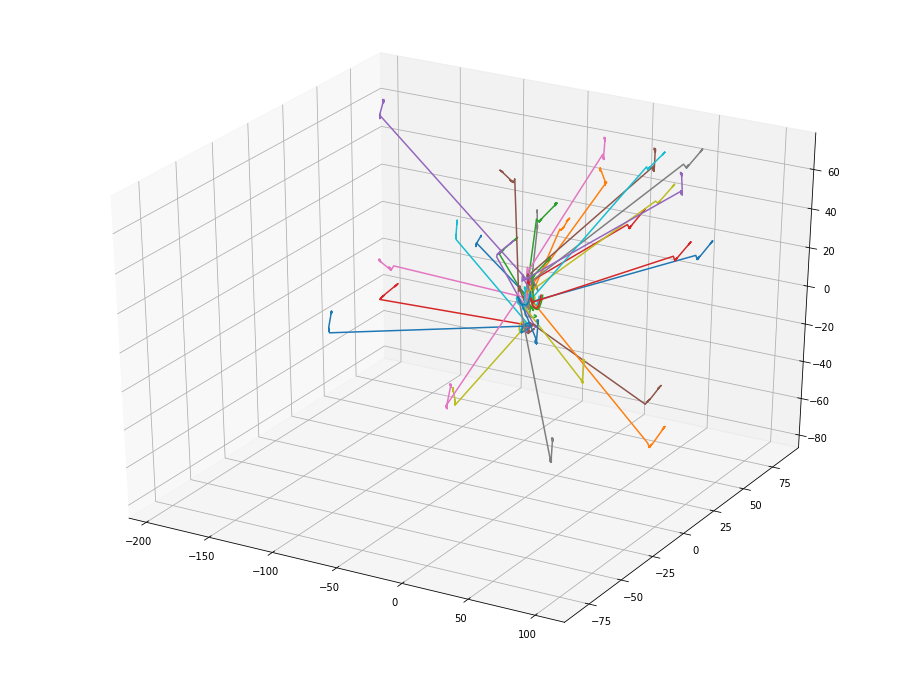

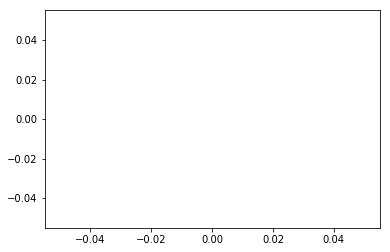

In [10]:
#plt.figure(1, figsize=(12, 5)); plt.ion()       # continuously plot

import random
from itertools import count
from tensorflow.python.framework.errors_impl import NotFoundError, InvalidArgumentError

with tf.Session() as sess:
    #  Run the variable initializer (only once)
    sess.run(tf.global_variables_initializer())     # initialize var in graph
    
    try:
        saver.restore(sess, checkpoint_filename)
    except (NotFoundError, InvalidArgumentError) as e:
        pass
    else:
        # train
        global_step_ = \
        sess.run([ t_global_step], {})
        print("successfully reloading, at global step", global_step_)

    summary_writer = tf.summary.FileWriter('logs', sess.graph)
    fileName = "storage/loopingData.csv"
    data = np.genfromtxt(fileName, delimiter=",")  
    
    # Plot graph of loss
    lossHistory = []

    # Run 1000 times 
#     for j in count() :
#         # run through each file
#         fileName = "storage/loopingData.csv"
#         data = np.genfromtxt(fileName, delimiter=",")
#         try:
#             del final_s_
#         except:
#             pass

#         # don't generate data with generate function, do file processing and TF all at once in this cell

#         # main training part
#         for x, y in generate_training_data(data):
#             if 'final_s_' not in globals():                 # first run, no any hidden state
#                 feed_dict = {
#                     tf_x: x, 
#                     tf_y: y
#                 }
#             else:                                           # has hidden state, C_(t-1), so pass it to rnn
#                 feed_dict = {                               # any run after the first
#                     tf_x: x, 
#                     tf_y: y, 
#                     init_s: final_s_
#                 }

#             # train
#             _, pred_, final_s_, loss_, increment_global_step_op_, global_step_ = \
#             sess.run([train_op, outs, final_s, loss, t_increment_global_step_op, t_global_step], feed_dict)
#             lossHistory.append(loss_)            


#         if j%15 == 0: 
#             saver.save(sess, checkpoint_filename)
#             print("checkpoint")
#             print("j is: ", j)
#             print("global step is: ", global_step_)


#         # plotting
#         #plt.plot(steps, y.flatten(), 'r-'); plt.plot(steps, pred_.flatten(), 'b-')
#         #plt.ylim((-1.2, 1.2)); plt.draw(); plt.pause(0.05)





#     del final_s_              # delete final_s_
    list_to_stack = []
    for j in range(10):
        if 'final_s_' not in globals():      
            x = data[np.newaxis, 0:TIME_STEP, :]
            feed_dict = {
                tf_x: x, 
            }
            list_to_stack.append(centerData(x[0,:,:]))
        else:
            feed_dict = {
                tf_x: pred_, 
                init_s: final_s_
            }
        pred_, final_s_ = sess.run([outs, final_s], feed_dict)     # train
        list_to_stack.append(pred_[0,:,:])

vstack_output = np.vstack(list_to_stack)
np.savetxt("storage/vstack_output.csv", vstack_output, delimiter=",")

plotGraph(vstack_output)

HTML(pd.DataFrame(vstack_output).to_html())
#plt.ioff(); plt.show()

plt.plot(lossHistory)



(50, 3, 25)
(1100, 93)
(93, 1100)
(31, 3, 1100)


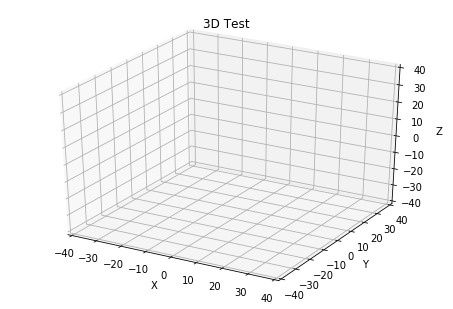

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
#%matplotlib inline
from IPython.display import HTML

def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = np.array([Gen_RandLine(25, 3) for index in range(50)])
print(data.shape)

data = np.genfromtxt("storage/vstack_output.csv", delimiter=",")
print(data.shape)

print(data.T.shape)
data = data.T.reshape(31,3,-1)
print(data.shape)

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([-40.0, 40.0])
ax.set_xlabel('X')

ax.set_ylim3d([-40.0, 40.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-40.0, 40.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 1100, fargs=(data, lines),
                                   interval=50, blit=False)

HTML(line_ani.to_html5_video())

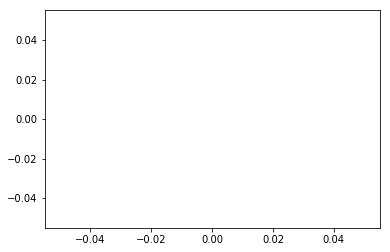

In [12]:
plt.plot(lossHistory[0:1000])

In [13]:
%%bash --bg

# Run tensorboard
if ps -A | grep "tensorboard" > /dev/null
then
    echo "Already running"
else
    tensorboard --logdir='logs'
fi

Starting job # 0 in a separate thread.


In [14]:
def centerAndPlot(data):
    data_c = data.copy()
    for j in range(1, data.shape[1]//3):
        data_c[:, j*3] -= data_c[:,0]
        data_c[:, j*3+2] -= data_c[:,2]
    
    data_c[:,0] = 0
    data_c[:,2] = 0
    
    plotGraph(data_c)
    
    
# alternate way of implementing centerAndPlot()
    
# data_c = data.copy()
# print(data_c.shape)
# data_c = data_c.reshape(data_c.shape[0],31,3)      #frames, joints, and coordinates
# print(data_c.shape)
# data_c[:,:,0] -= data_c[:,0:1,0]                   #x-coordinates
# data_c[:,:,2] -= data_c[:,0:1,2]                   #z-coordinates

# data_c = data_c.reshape(data_c.shape[0],93)        #reshaping back to frames and columns

ValueError: input operand has more dimensions than allowed by the axis remapping

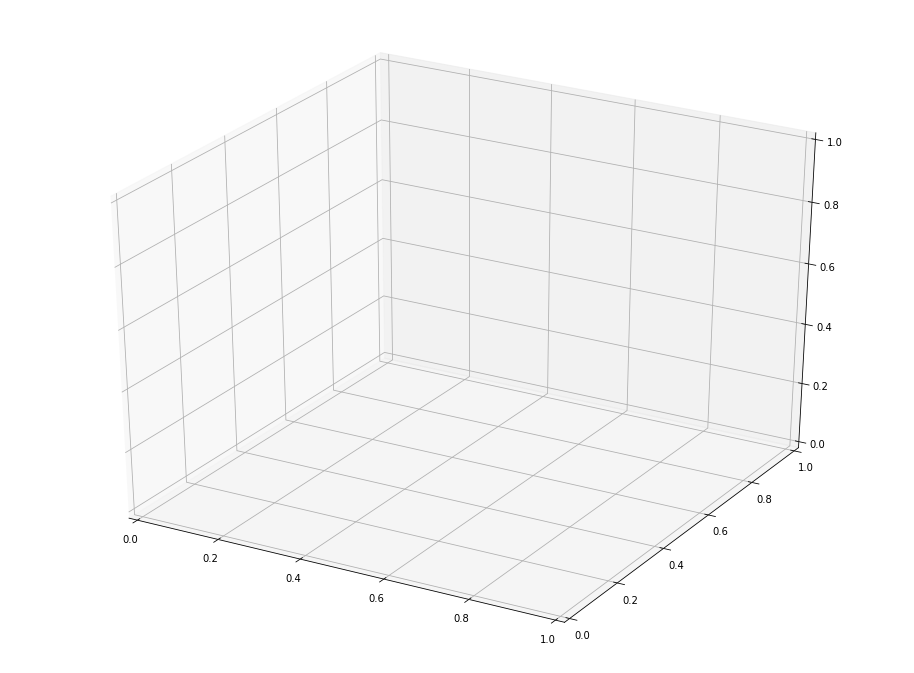

In [15]:
centerAndPlot(data)

In [ ]:
# every frame - average your existing position against new position
# create new array with same shape as data called smooth data
# copy x coord of one onto other - row 0 

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# averaging "shaves off" the short peaks & valleys but keep big ones, basically getting rid of the noise in the
# motion capture data, if there is any. 
# setting alpha very low = very smooth data
# setting alpha close to 1 - not really smoothing at all.

alpha = .02       #20 percent
smooth_data = data.copy()
smooth_data[0,:] = data[0,:]
for i in range(smooth_data.shape[0] - 1):
    smooth_data[i+1,:] = (1-alpha)*smooth_data[i,:] + alpha*data[i+1,:]       #1-alpha is 80 percent
    
centerAndPlot(smooth_data)

# plot smooth_data
#fig = plt.figure(figsize=(16, 12)) 
#ax = fig.gca(projection='3d')
#for j in range(data.shape[1]//3): 
    #x = smooth_data[:,j*3] - smooth_data[:,0]
    #z = smooth_data[:,j*3+1]
    #y = smooth_data[:,j*3+2] - smooth_data[:,2]
    #ax.plot(x, y, z)

#plt.show()

In [ ]:
# Get a link to the tensorboard (if it's running) for convenience.

import requests
from IPython.display import HTML, display

try:
    print("Global ip address is " + str(global_ip_addr))
except:
    print("Global ip address unknown.  Attempting to fetch it.")
    global_ip_addr = requests.get("http://ipinfo.io/ip", timeout=1).text.strip()
    print("Obtained: " + global_ip_addr)

tensorboard_url = "http://" + global_ip_addr + ":6006"
tensorboard_link = '<a href="' + tensorboard_url + '">Tensorboard Site</a>'

display(HTML(tensorboard_link))

try:
    r = requests.head(tensorboard_url, timeout=1)
    print("Tensorboard site appears to be running")
except requests.exceptions.RequestException as e:
    print("Note: tensoboard site appears down; try starting it.")
    print("The next cell after this one should do it;")
    print("otherwise, bring up a terminal, and type ")
    print("   tensorboard --logdir='logs' ")



# RNN

Based on https://github.com/MorvanZhou/Tensorflow-Tutorial/blob/master/tutorial-contents/403_RNN_regression.py by Morvan Zhou

Morvan Zhou made a Youtube video based on this code: https://www.youtube.com/user/MorvanZhou (you'll want to follow along with the code at the github link above though)

More tutorials by Morvan Zhou: https://morvanzhou.github.io/tutorials/

Dependencies:
*  tensorflow 1.1.0
*  matplotlib
*  numpy

<img src="tasks.png" alt="tasks" style="width: 50%;"/>

## Long Short-Term Memory Networks
Notes by Ed
### How it works once training is finished

The following diagram is taken from, and explained by, [this medium article](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714) which more or less follows this [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), but has better diagrams.  It's a diagram of a single LSTM cell.

<img src="https://cdn-images-1.medium.com/max/1000/1*laH0_xXEkFE0lKJu54gkFQ.png" alt="LSTM diagram" style="width: 50%;"/>

I'm not going to attempt to talk about the whole thing.  It may be useful in the future to understand some more of the anatomy, but first I want to call attention to just the inputs and outputs. $X_t$ is a vector of input data associated with time step $t$.  In our case, $X_t$ is a 93-element vector, or 3 elements ($x,y,$ and $z$ coordinates) for each of 31 joints in mocap data.  Likewise, $h_t$ is the output, and is also a 93-element vector.  $X_t$ corresponds to `tf_x` and $h_t$ corresponds to `pred_` in the code.  The line 

`rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=CELL_SIZE)`

creates all the rest of what you see, all the $\sigma$ and tanh nodes and the elementwise additions and subtractions, at least assuming TensorFlow uses the same architecture as the authors of that diagram (I can't yet verify that).  

Each time step $t$ (each frame of the mocap data, 120 frames per second), we push an input vector $X_t$ through a bunch of math using `sess.run`, that math is sensitive to a handful of *weight matrices* and *bias vectors* that can be tailored to our purposes, and then get an output vector $h_t$ out the other side. *Training* is the process of figuring out good weight matrices and bias vectors.  Typically you figure out your weight matrices and bias vectors, and then freeze them (fix them).

The math is sensitive to the weight matrices and bias vectors because at a handful of points in the above pipeline, a vector $v$ (one of the black lines) is transformed into a new vector $v'$ by the transformation

$v'=W\cdot v + b$,

i.e., a matrix multiplication by $W$ followed by a vector addition with $b$.  Each such location in the pipeline has its own separate weight matrix $W$ and bias vector $b$.  So the process of getting an $h_t$ involves, among other things, about half a dozen matrix multiplications using half a dozen distinct matrices (not really shown in the figure). To see how matrix multiplication and addition of biases, together with squashing functions like sigmoid and tanh, can lead to interesting behavior, see [Google's Tensorflow Playground](https://playground.tensorflow.org), which we looked at together a bit ago.

Now I haven't talked at all about how to get good weight matrices and bias vectors.  I'm just assuming we already have them.  Even so, this neural network should be learning a **process**, that's why we're using an RNN.  In non-recurrent neural networks, once you've figured out your $W$s and $b$s and frozen them, you always get the same outputs for the same inputs.  That's not a process.  So an RNN cell also outputs a little extra info that affects how it runs the next time.  That's where $C_t$ comes in, represented in the code by `init_s` and `final_s`.  Once you put in $X_0$, you get your $h_0$ and then the network yields a $C_0$ that then gets fed back into the RNN for when you put in $X_1$.  So in a sense, the network really looks like this:

<img src="https://cdn-images-1.medium.com/max/1875/1*S0Y1A3KXYO7_eSug_KsK-Q.png" alt="LSTM unrolled"/>

So you push a chain of $X_t$ vectors, 93 elements for each $t$, through some math involving some matrices $W$ and vectors $b$, and get out a chain of $h_t$ vectors, also 93 elements each.  The network transforms the process described by the $X_t$ into the process described by $h_t$.  One runaway success for this has been machine translation as in French to English.  Another, for example, would be for me to train a network to transform recordings of my own voice into Patrick Stewart saying the same things.  I'd love to have Patrick Stewart's voice.

### Training
All that, and I still haven't talked about training.  Everything so far happens even if $W$ and $b$ never change.  Fortunately, TensorFlow is designed to use some pretty serious calculus to gradually figure out what each of our handful of $W$ matrices and $b$ vectors should be.  We just give it a lot of examples of the outputs $Y_t$ we want for every input $X_t$, and it brings the network outputs $h_t$ into alignment with the outputs $Y_t$ by process of gradual adjustment of the $W$'s and $b$'s.

### What do we do now?
Here's the tasks as I see them:
1. We need to figure out how to represent our data so that it goes well into the RNN.  We have mocap data for our $X_t$, each $t$ is a frame, but what $Y_t$ should we train the RNN to produce?  The paper we started with should have some suggestions, but it's also missing some details.
1. We need to decide if the RNN's structure needs to be customized.  Do we add extra blocks to the pipeline?  The more crap you add, the more flexible the RNN gets in terms of what it's capable of learning, but also, the greater the chance it will get "confused" in the sense of overfitting.
1. Figure out where MDN's (mixture density networks) fit into all of this, if they're needed.  The authors used them.
1. We need good visualization.  The more we can plot, the more we can use our imaginations to guide us.  But a vector of 93 elements is a point in 93-dimensional space.  Most people (myself included) can't imagine four dimensions, let alone 93.  One idea is a 3d plot where each joint is a curve in the plot.  But I don't know how to do that in matplotlib.